##TourchVision

In [ ]:
!pip install torch torchvision --quiet

In [ ]:
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.eval()
model.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 118MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
preprocess = weights.transforms()

In [ ]:
meta = getattr(weights, "meta", {}) or {}
CLASS_NAMES = meta.get("categories", None)

In [ ]:
def segment_with_torchvision(image_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    h_img, w_img = img_np.shape[:2]

    input_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)["out"][0] # [1, num_classes, H, W]

    predicted_classes = output.argmax(0).cpu().numpy()

    num_classes = predicted_classes.max() + 1
    cmap = plt.get_cmap("tab20", num_classes)
    palette = (cmap(range(num_classes))[:, :3] * 255).astype(np.uint8)

    color_mask = palette[predicted_classes]

    mask_img = Image.fromarray(color_mask)
    mask_img = mask_img.resize((w_img, h_img), resample=Image.NEAREST)
    color_mask_resized = np.array(mask_img)

    alpha = 0.5 # прозрачность маски
    overlay = (img_np * (1 - alpha) + color_mask_resized * alpha).astype(np.uint8)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Оригинальное изображение")
    plt.axis("off")
    plt.imshow(img_np)

    plt.subplot(1, 2, 2)
    plt.title("TorchVision DeepLabV3 — сегментация")
    plt.axis("off")
    plt.imshow(overlay)

    plt.show()

In [ ]:
from pathlib import Path

def run_on_folder(folder_path, segment_fn, desc=None):
    """
    folder_path: путь к папке с изображениями
    segment_fn: функция, которая принимает (image_path: str)
    desc: описание функции (для печати), можно не передавать
    """
    folder = Path(folder_path)
    exts = {".jpg", ".jpeg", ".png", ".bmp"}

    image_paths = sorted(
        [p for p in folder.iterdir() if p.suffix.lower() in exts]
    )

    if not image_paths:
        print(f"В папке {folder} нет изображений с расширениями {exts}")
        return

    if desc is None:
        desc = segment_fn.__name__

    print(f"Будем обрабатывать функцией: {desc}")

    for img_path in image_paths:
        print(f"\n[{desc}] Обрабатываю: {img_path.name}")
        segment_fn(str(img_path))


In [ ]:
run_on_folder("/content/data/images/street", segment_with_torchvision)

Будем обрабатывать функцией: segment_with_torchvision

[segment_with_torchvision] Обрабатываю: 1.jpg


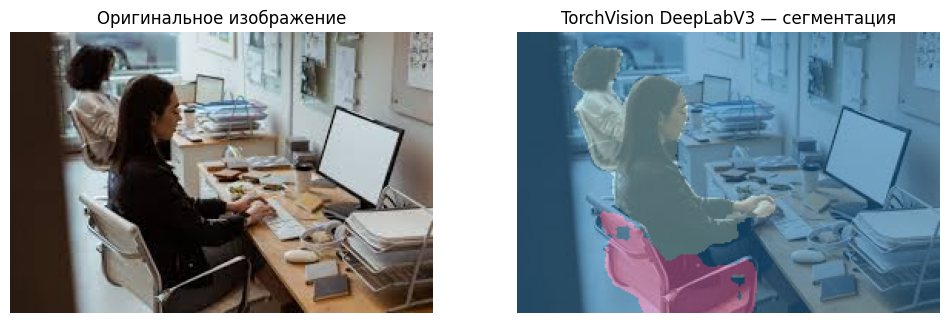


[segment_with_torchvision] Обрабатываю: 2.jpg


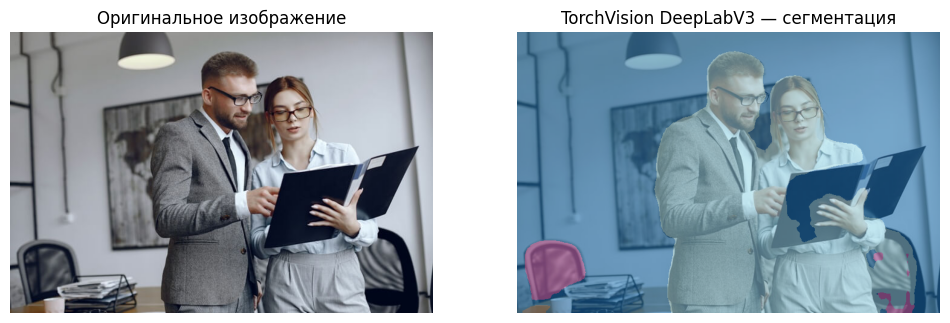


[segment_with_torchvision] Обрабатываю: 3.jpg


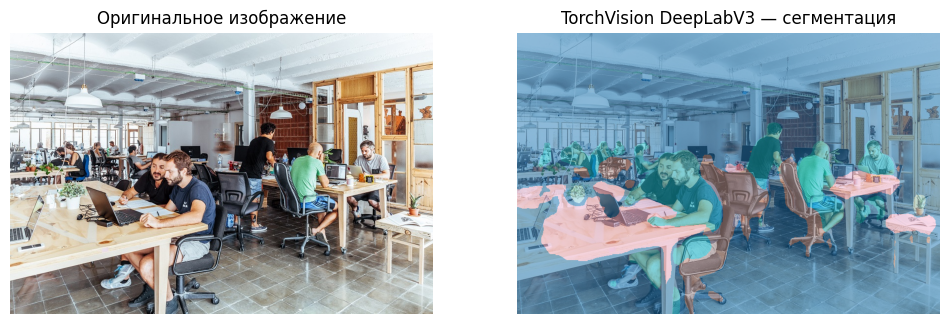


[segment_with_torchvision] Обрабатываю: 4.jpeg


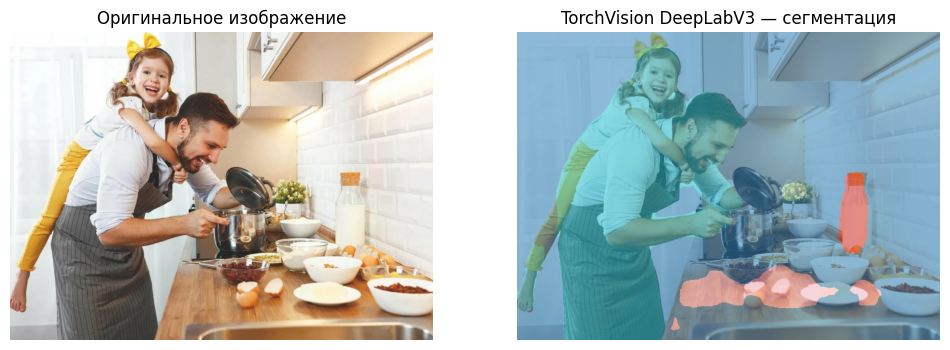


[segment_with_torchvision] Обрабатываю: 5.jpg


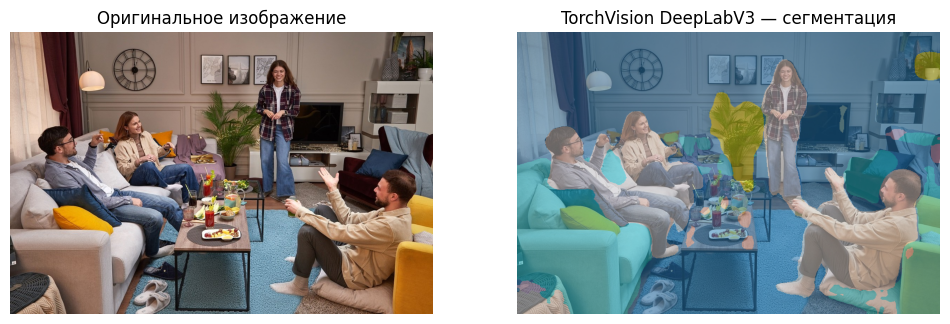

In [ ]:
run_on_folder("/content/data/images/indoor", segment_with_torchvision)

## YOLO

In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
yolo_model = YOLO("yolov8s-seg.pt")

In [ ]:
def segment_with_yolo(image_path):
    results = yolo_model(image_path)
    res = results[0]

    annotated_bgr = res.plot(labels=False)

    boxes = res.boxes
    names = res.names

    if boxes is not None and len(boxes) > 0:

        for box, cls in zip(boxes.xyxy, boxes.cls):
            x1, y1, x2, y2 = box.int().tolist()
            class_id = int(cls)
            label = names[class_id]

            text_x = x1
            text_y = y1 - 10
            if text_y < 0:
                text_y = y1 + 20

            (text_w, text_h), baseline = cv2.getTextSize(
                label,
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.6,
                thickness=2
            )

            cv2.putText(
                annotated_bgr,
                label,
                (text_x, text_y),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(255, 255, 255),
                thickness=2,
                lineType=cv2.LINE_AA
            )

    annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.title("YOLOv8-seg")
    plt.axis("off")
    plt.imshow(annotated_rgb)
    plt.show()

In [ ]:
run_on_folder("/content/data/images/street", segment_with_yolo)

Будем обрабатывать функцией: segment_with_yolo

[segment_with_yolo] Обрабатываю: 1.jpg

image 1/1 /content/data/images/indoor/1.jpg: 448x640 2 persons, 1 chair, 2 tvs, 1 laptop, 1 mouse, 2 books, 16.5ms
Speed: 2.9ms preprocess, 16.5ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


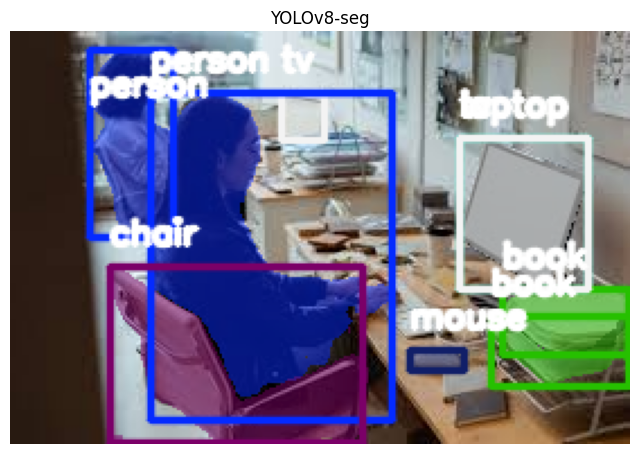


[segment_with_yolo] Обрабатываю: 2.jpg

image 1/1 /content/data/images/indoor/2.jpg: 448x640 2 persons, 1 tie, 2 chairs, 1 dining table, 2 laptops, 1 book, 28.7ms
Speed: 11.1ms preprocess, 28.7ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


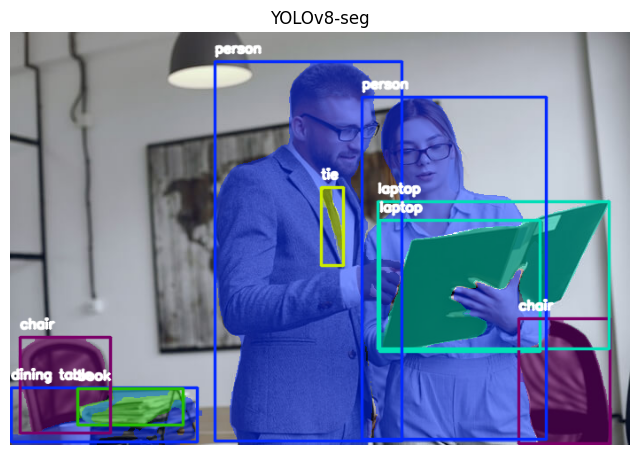


[segment_with_yolo] Обрабатываю: 3.jpg

image 1/1 /content/data/images/indoor/3.jpg: 448x640 9 persons, 2 cups, 7 chairs, 2 potted plants, 3 dining tables, 2 tvs, 5 laptops, 1 cell phone, 49.1ms
Speed: 9.2ms preprocess, 49.1ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


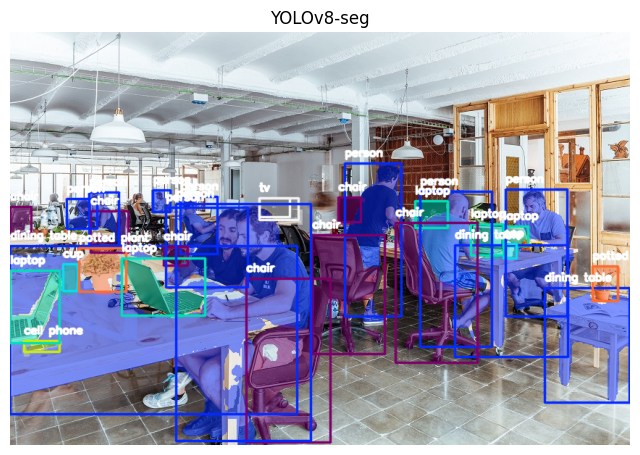


[segment_with_yolo] Обрабатываю: 4.jpeg

image 1/1 /content/data/images/indoor/4.jpeg: 480x640 2 persons, 1 bottle, 1 spoon, 7 bowls, 1 potted plant, 17.7ms
Speed: 3.9ms preprocess, 17.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


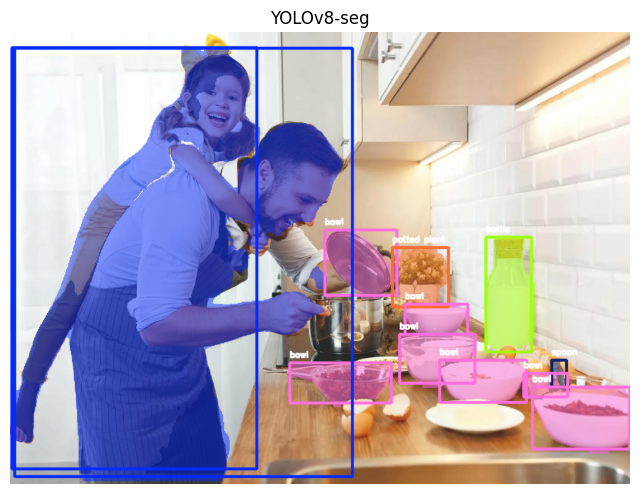


[segment_with_yolo] Обрабатываю: 5.jpg

image 1/1 /content/data/images/indoor/5.jpg: 448x640 4 persons, 1 bottle, 4 cups, 1 bowl, 1 chair, 3 couchs, 3 potted plants, 1 dining table, 1 tv, 1 clock, 17.4ms
Speed: 3.6ms preprocess, 17.4ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)


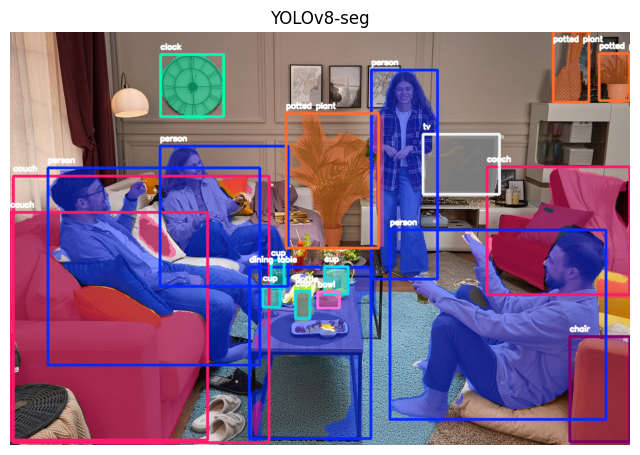

In [ ]:
run_on_folder("/content/data/images/indoor", segment_with_yolo)

Будем обрабатывать функцией: segment_with_yolo

[segment_with_yolo] Обрабатываю: lungs.jpg

image 1/1 /content/data/images/misc/lungs.jpg: 640x640 1 person, 4 ties, 21.9ms
Speed: 3.5ms preprocess, 21.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


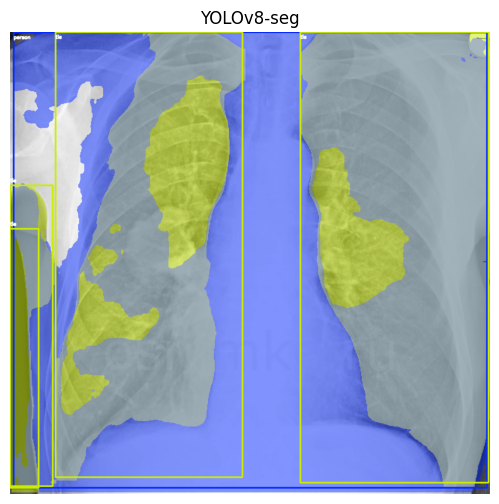


[segment_with_yolo] Обрабатываю: mrt_brain.jpg

image 1/1 /content/data/images/misc/mrt_brain.jpg: 640x640 1 clock, 21.2ms
Speed: 4.3ms preprocess, 21.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


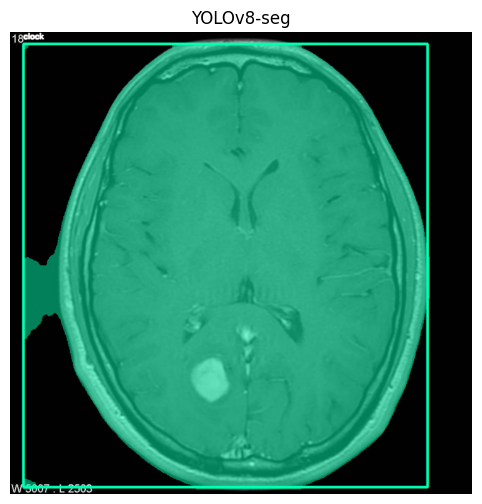


[segment_with_yolo] Обрабатываю: satellite.jpg

image 1/1 /content/data/images/misc/satellite.jpg: 416x640 (no detections), 17.6ms
Speed: 2.9ms preprocess, 17.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


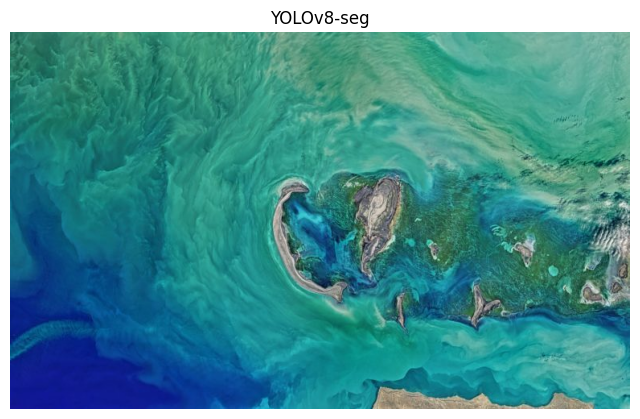


[segment_with_yolo] Обрабатываю: satellite_2.jpg

image 1/1 /content/data/images/misc/satellite_2.jpg: 384x640 (no detections), 15.0ms
Speed: 2.9ms preprocess, 15.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


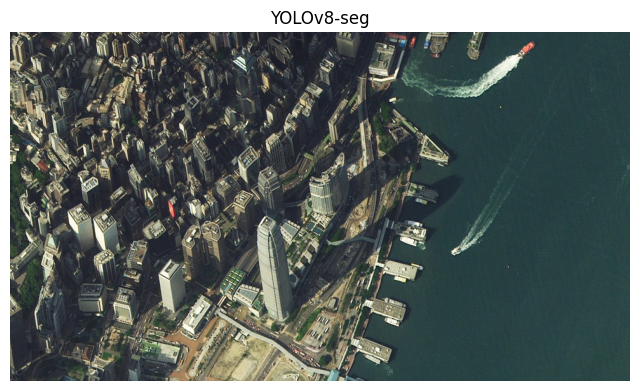

In [ ]:
run_on_folder("/content/data/images/misc", segment_with_yolo)

## Detectron2

In [ ]:
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git' --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.2 MB/s eta 0:00:00


In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
def setup_detectron2_instance():
    cfg = get_cfg()
    # Берём готовый конфиг для instance-сегментации COCO
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    ))
    # Порог уверенности
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    # Готовые веса
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )

    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    predictor = DefaultPredictor(cfg)
    return cfg, predictor

detectron_cfg, detectron_predictor = setup_detectron2_instance()
# Метаданные: тут лежат имена COCO-классов
detectron_metadata = MetadataCatalog.get(detectron_cfg.DATASETS.TRAIN[0])
print("Классов в COCO:", len(detectron_metadata.thing_classes))

model_final_f10217.pkl: 178MB [00:01, 101MB/s]                           


Классов в COCO: 80


In [ ]:
def segment_with_detectron2(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Не удалось прочитать изображение: {image_path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    outputs = detectron_predictor(img_rgb)
    instances = outputs["instances"].to("cpu")

    # Визуализация масок/боксов/классов
    v = Visualizer(img_rgb, metadata=detectron_metadata, scale=1.0)
    out = v.draw_instance_predictions(instances)

    result_rgb = out.get_image()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Оригинальное изображение")
    plt.axis("off")
    plt.imshow(img_rgb)

    plt.subplot(1, 2, 2)
    plt.title("Detectron2 Mask R-CNN")
    plt.axis("off")
    plt.imshow(result_rgb)

    plt.show()

    # Выводим найденные классы в консоль
    if len(instances) == 0:
        print("Detectron2: объекты не найдены.")
        return

    pred_classes = instances.pred_classes.numpy()
    unique_ids, counts = np.unique(pred_classes, return_counts=True)

    print("Detectron2 — найденные классы:")
    for cid, cnt in zip(unique_ids, counts):
        # имя класса из thing_classes
        if cid < len(detectron_metadata.thing_classes):
            name = detectron_metadata.thing_classes[cid]
        else:
            name = f"class_{cid}"
        print(f"- id={cid:2d}, name={name:12s}, instances={cnt}")


In [ ]:
run_on_folder("/content/data/images/street", segment_with_detectron2)

In [ ]:
run_on_folder("/content/data/images/indoor", segment_with_detectron2)

Будем обрабатывать функцией: segment_with_detectron2

[segment_with_detectron2] Обрабатываю: lungs.jpg


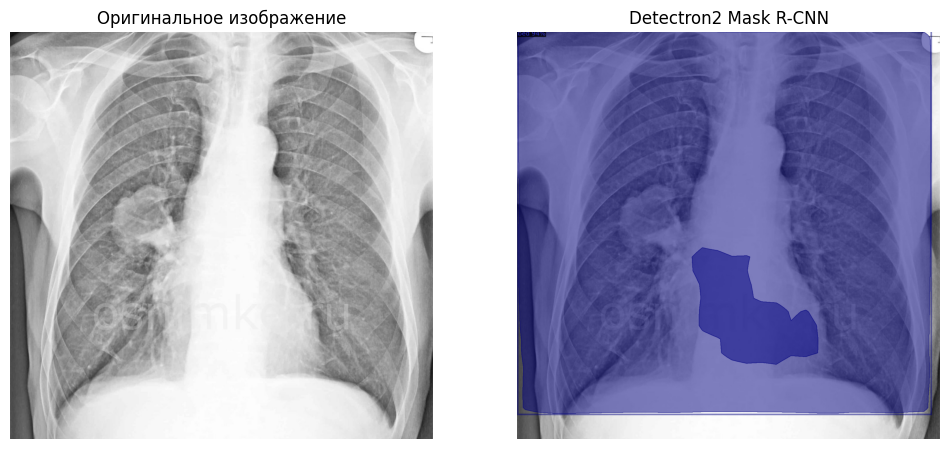

Detectron2 — найденные классы:
- id=59, name=bed         , instances=1

[segment_with_detectron2] Обрабатываю: mrt_brain.jpg


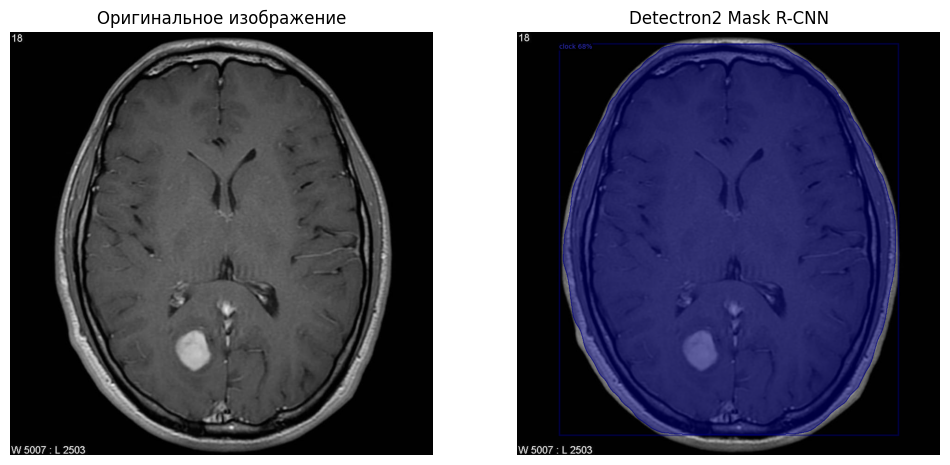

Detectron2 — найденные классы:
- id=74, name=clock       , instances=1

[segment_with_detectron2] Обрабатываю: satellite.jpg


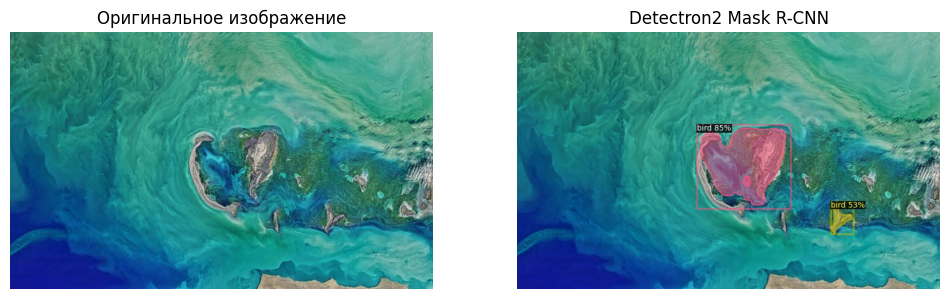

Detectron2 — найденные классы:
- id=14, name=bird        , instances=2

[segment_with_detectron2] Обрабатываю: satellite_2.jpg


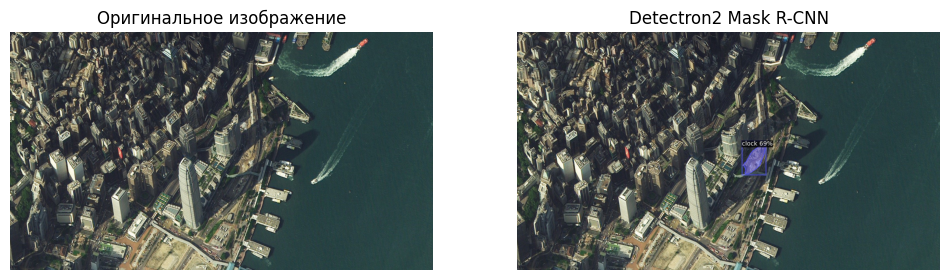

Detectron2 — найденные классы:
- id=74, name=clock       , instances=1


In [ ]:
run_on_folder("/content/data/images/misc", segment_with_detectron2)

### MMSegmentation

In [ ]:
!pip3 install -q openmim
!mim install -q mmengine
!mim install -q "mmcv>=2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.8 MB/s eta 0:00:00

In [ ]:
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!git checkout main
!pip install -q -e .

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mmcv

from mmseg.apis import MMSegInferencer

In [ ]:
MMSEG_MODEL_NAME = 'deeplabv3plus_r18-d8_4xb2-80k_cityscapes-512x1024'

mmseg_inferencer = MMSegInferencer(
    model=MMSEG_MODEL_NAME,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print("MMSegInferencer инициализирован.")

In [ ]:
def segment_with_mmseg(image_path):
    """
    Сегментация картинки с помощью MMSegmentation (DeeplabV3+ на Cityscapes).

    image_path: путь к изображению (строка).
    """

    result = mmseg_inferencer(image_path, show=False)

    vis = result['visualization']
    pred = result['predictions']

    # mmcv читает в BGR
    img_bgr = mmcv.imread(image_path)
    img_rgb = mmcv.bgr2rgb(img_bgr)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Оригинальное изображение")
    plt.axis("off")
    plt.imshow(img_rgb)

    plt.subplot(1, 2, 2)
    plt.title("MMSegmentation — сегментация")
    plt.axis("off")
    plt.imshow(vis)

    plt.show()

    mask = np.array(pred)
    unique_ids, counts = np.unique(mask, return_counts=True)

    classes = mmseg_inferencer.dataset_meta.get('classes', None)

    non_bg = unique_ids != 0
    unique_ids = unique_ids[non_bg]
    counts = counts[non_bg]

    if len(unique_ids) == 0:
        print("MMSeg: только фон, объекты не найдены.")
        return

    total_pixels = mask.size
    print("MMSeg — найденные классы (без фона):")
    for cid, cnt in zip(unique_ids, counts):
        perc = cnt / total_pixels * 100

        if classes is not None and cid < len(classes):
            name = classes[cid]
        else:
            name = f"class_{cid}"

        print(f"- id={cid:2d}, name={name:15s}, pixels={cnt}, ~{perc:.2f}%")


### SMP (segmentation_models_pytorch)

In [ ]:
!pip install segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import numpy as np
from pathlib import Path

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
voc_root = "/content/data/voc"

voc_train = VOCSegmentation(
    root=voc_root,
    year="2012",
    image_set="train",
    download=True,
)

KeyboardInterrupt: 

In [ ]:
class VOCDatasetForSMP(Dataset):
    def __init__(self, voc_dataset, image_size=(256, 256)):
        self.voc = voc_dataset
        self.image_size = image_size

        self.img_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),  # [0,1]
        ])

        self.mask_resize = transforms.Resize(
            image_size,
            interpolation=transforms.InterpolationMode.NEAREST
        )

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        img, mask = self.voc[idx]

        img_tensor = self.img_transform(img)

        mask_resized = self.mask_resize(mask)
        mask_np = np.array(mask_resized, dtype=np.int64)
        mask_tensor = torch.from_numpy(mask_np)

        return img_tensor, mask_tensor


In [ ]:
voc_smp_dataset = VOCDatasetForSMP(voc_train, image_size=(256, 256))
voc_loader = DataLoader(voc_smp_dataset, batch_size=4, shuffle=True)

print("VOC SMP dataset size:", len(voc_smp_dataset))

images, masks = next(iter(voc_loader))
print("images shape:", images.shape)
print("masks shape:", masks.shape)

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
NUM_VOC_CLASSES = 21

In [ ]:
model_smp_voc = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_VOC_CLASSES,
).to(device)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model_smp_voc.parameters(), lr=1e-3)

def train_smp_voc(model, loader, device, max_batches=50):
    model.train()
    running_loss = 0.0

    loop = tqdm(enumerate(loader), total=max_batches, desc="Train SMP UNet (VOC)")
    for i, (images, masks) in loop:
        if i >= max_batches:
            break

        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (i + 1))

    return running_loss / max_batches

avg_loss = train_smp_voc(model_smp_voc, voc_loader, device, max_batches=50)
print("Средний loss:", avg_loss)


In [ ]:
voc_model_path = "/content/smp_unet_voc.pth"
torch.save(model_smp_voc.state_dict(), voc_model_path)
print("Модель сохранена в", voc_model_path)

In [ ]:
import matplotlib.pyplot as plt

def load_smp_voc_model(weights_path):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None, # веса энкодера нам уже не нужны, мы загрузим всё из state_dict
        in_channels=3,
        classes=NUM_VOC_CLASSES,
    ).to(device)

    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

# Загружаем модель из файла
model_smp_voc_infer = load_smp_voc_model(voc_model_path)

def segment_with_smp_voc(image_path):
    """
    Сегментация одной картинки обученным SMP UNet (VOC).
    """
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    h, w = img_np.shape[:2]

    # ресайзим до 256x256 как в датасете
    transform_img = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    img_tensor = transform_img(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model_smp_voc_infer(img_tensor)
        pred = torch.argmax(logits, dim=1)[0].cpu().numpy()

    num_classes = NUM_VOC_CLASSES
    cmap = plt.get_cmap("tab20", num_classes)
    palette = (cmap(range(num_classes))[:, :3] * 255).astype(np.uint8)
    color_mask_small = palette[pred] # [256,256,3]

    mask_img = Image.fromarray(color_mask_small)
    mask_img = mask_img.resize((w, h), resample=Image.NEAREST)
    color_mask = np.array(mask_img)

    alpha = 0.5
    overlay = (img_np * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Оригинал")
    plt.axis("off")
    plt.imshow(img_np)

    plt.subplot(1, 2, 2)
    plt.title("SMP UNet (VOC)")
    plt.axis("off")
    plt.imshow(overlay)
    plt.show()

    # статистика по классам
    unique_ids, counts = np.unique(pred, return_counts=True)
    total_pixels = pred.size
    print("SMP VOC — классы (id и доля пикселей):")
    for cid, cnt in zip(unique_ids, counts):
        perc = cnt / total_pixels * 100
        print(f"- id={cid:2d}, pixels={cnt}, ~{perc:.2f}%")


Пример SMP:

https://colab.research.google.com/github/qubvel-org/segmentation_models.pytorch/blob/main/examples/camvid_segmentation_multiclass.ipynb

Ниже — сводная таблица по **шести исходным библиотекам**:
- TorchVision
- YOLO
- Detectron2
- SMP (Segmentation Models PyTorch)
- MMSegmentation
- opencv-python

| Библиотека | Типы сегментации «из коробки» | На каких данных обычно обучены готовые модели | Какие объекты / сцены лучше всего сегментируются |
|-----------|--------------------------------|-----------------------------------------------|--------------------------------------------------|
| **TorchVision (segmentation)** | Семантическая (FCN, DeepLabV3, LR-ASPP и т.п.), instance-сегментация (Mask R-CNN, etc.) | Предобученные модели обычно на **COCO** (80 классов) и VOC-подобных разметках (около 20 базовых классов) | Повседневные сцены: **люди**, **машины/транспорт**, **животные**, **бытовые предметы**, **мебель**, простые уличные и домашние сцены |
| **YOLO (Ultralytics, -seg модели)** | Instance-сегментация (маска + bounding box для каждого объекта) | Типичные веса (`yolov8s-seg.pt`, `yolov8n-seg.pt` и т.п.) обучены на **MS COCO** (80 классов «common objects in context») | Отдельные объекты с чёткими контурами: **person, car, bus, truck, bicycle, dog, cat, bottle, chair** и т.п.; хорошо работает на уличных и бытовых сценах, где нужно выделить каждый объект по отдельности |
| **Detectron2** | Семантическая, instance и panoptic сегментация (Mask R-CNN, PanopticFPN, etc.) | Готовые модели обучены на **COCO**, **Cityscapes**, **LVIS**, **ADE20K**, иногда Pascal VOC | 1) **Общие объекты** (люди, транспорт, предметы) по COCO. 2) **Городские сцены** (дорога, тротуар, здания, машины, пешеходы, разметка, светофоры) по Cityscapes. 3) Есть редкие классы (LVIS/ADE20K) |
| **SMP (Segmentation Models PyTorch)** | Набор архитектур: UNet, FPN, DeepLabV3(+), LinkNet, PSPNet и др. — может делать и бинарную, и мультиклассовую сегментацию | **Нет фиксированного сегментационного датасета.** В SMP предобучены только **энкодеры на ImageNet**, а дальше обучаем на СВОИХ данных (VOC, Cityscapes, медицина, спутник и т.п.) | Не заточен под конкретные объекты сам по себе. **Лучше всего подходит как конструктор**: можно обучить под что угодно — дороги, органы, сосуды, здания, поля, дефекты на металл/тканях и т.д. |
| **MMSegmentation (OpenMMLab)** | В основном семантическая сегментация, есть модели и для panoptic; огромное количество архитектур (DeepLab, UPerNet, SegFormer, etc.) | Есть веса под **Cityscapes**, **ADE20K**, **COCO-Stuff**, а также под **remote sensing** (спутниковые карты) и **медицинские датасеты** (сосуды, структуры на изображениях) | Очень хорошо подходит для: 1) **автодрайвинга и городских сцен** (дорога, разметка, здания, люди, машины). 2) **общих сцен** внутри/снаружи (стены, мебель, небо, трава). 3) **спутниковых изображений** (здания, дороги, вода, растительность). 4) **медицины** (сосуды, органы, ткани) при выборе соответствующих чекпоинтов |
| **opencv-python (OpenCV)** | Классические алгоритмы сегментации: thresholding, GrabCut, watershed, superpixels, k-means и т.п.; сам **не обучен ни на каком сегментационном датасете** — это библиотека алгоритмов. | Без нейросетей — хорошо подходит для задач типа **отделить объект от фона**, выделить крупные области, сделать грубую маску по цвету/яркости. Для настоящей семантической или instance-сегментации нужен внешний обученный модельный вес